In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# general libraries
import time
import math
import numpy as np
from shapely import geometry
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pickle
import networkx as nx

# JAX
import jax
import jax.numpy as jnp
import jraph
import numpy as np
import haiku as hk
import optax

# Numpyro
import numpyro
from numpyro.infer import SVI, MCMC, NUTS, init_to_median, Predictive, RenyiELBO
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro import optim

from model import VGAE

/Users/salmanfaris/miniforge3/envs/prior-vgae/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [3]:
rng_key = jax.random.PRNGKey(42)

In [4]:
def plot_samps(draws, columns=4, rows=3, figsize = (19,12), ttl="CAR priors"):
    fig, axs = plt.subplots(rows, columns, figsize=figsize)
    _min, _max = np.amin(draws[0:columns*rows]), np.amax(draws[0:columns*rows])
    for r in range(rows):
        for c in range(columns):
            im = axs[r, c].imshow(draws[r*columns + c].reshape(num_y, num_x), 
                                  cmap='viridis', interpolation='none', #extent=[0,1,0,1], 
                                  origin='lower')
                                  #,vmin=_min, vmax=_max)
            axs[r, c].set_title("draw "+str(r*columns + c))  
            fig.colorbar(im, ax=axs[r, c])
    fig.suptitle(ttl, fontsize=16)
    plt.show()
    
def plot_truth_estimate(y_true, mean_post_pred_vae, ttl1="Ground truth", ttl2="CAR estimate"):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    _min, _max = np.amin([y_true, mean_post_pred_vae]), np.amax([y_true, mean_post_pred_vae])

    im = axs[0].imshow(y_true.reshape(num_y, num_x), 
                       cmap='viridis', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)
    fig.colorbar(im, ax=axs[0])
    axs[0].set_title(ttl1)  

    im = axs[1].imshow(mean_post_pred_vae.reshape(num_y, num_x), 
                       cmap='viridis', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)

    fig.colorbar(im, ax=axs[1])
    axs[1].set_title(ttl2) 
    
def plot_truth_car_vae(y_true, mean_post_pred_car, mean_post_pred_vae, 
                       ttl1="Ground truth", ttl2="CAR estimate", ttl3="VAE estimate"):
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    _min = np.amin([y_true, mean_post_pred_car, mean_post_pred_vae])
    _max = np.amax([y_true, mean_post_pred_car, mean_post_pred_vae])

    im = axs[0].imshow(y_true.reshape(num_y, num_x), 
                       cmap='viridis', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)
    fig.colorbar(im, ax=axs[0])
    axs[0].set_title(ttl1)  

    im = axs[1].imshow(mean_post_pred_car.reshape(num_y, num_x), 
                       cmap='viridis', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)

    fig.colorbar(im, ax=axs[1])
    axs[1].set_title(ttl2)
    
    im = axs[2].imshow(mean_post_pred_vae.reshape(num_y, num_x), 
                       cmap='viridis', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)

    fig.colorbar(im, ax=axs[2])
    axs[2].set_title(ttl3)

In [5]:
# Grid.
k = 1
num_x = 15 * k
num_y = 10 * k

# Polygons.
pols = []
for j in range(num_y):
  for i in range(num_x):
    coords = [(i,j), (i+1, j), (i+1, j+1), (i, j+1), (i,j)]
    p = Polygon(coords)
    pols.append(p)
    
N = len(pols)

# Adjacency matrix.
A = np.zeros(shape=(N,N))
for i in range(N):
  for j in range(i+1,N):
    if (pols[i].intersection(pols[j]).length > 0):
      A[i,j] = 1
      A[j,i] = 1

# Number of neighbours.
d = A.sum(axis=0)
D = jnp.diag(d)
np.linalg.det(np.linalg.inv(D - A))

0.0

In [6]:
def CAR(args):
  A = args["A"]
  d = args["d"]
  D = jnp.diag(d)

  #alpha = numpyro.sample('alpha', dist.Uniform(low=0.01, high=0.999))
  alpha = numpyro.sample('alpha', dist.Uniform(low=0.4, high=0.999))

  Q = (D - alpha * A)
  car = numpyro.sample('car', dist.MultivariateNormal(loc=jnp.zeros(N), precision_matrix=Q))

In [7]:
args = {# data
  "d": d,
  "A": A,
  "batch_size": 100
}

In [8]:
# CAR: prior predictive
rng_key, car_pred_rng = jax.random.split(rng_key)

car_predictive = Predictive(CAR, num_samples=args["batch_size"])
car_preds = car_predictive(car_pred_rng, args)
car_draws = car_preds['car']

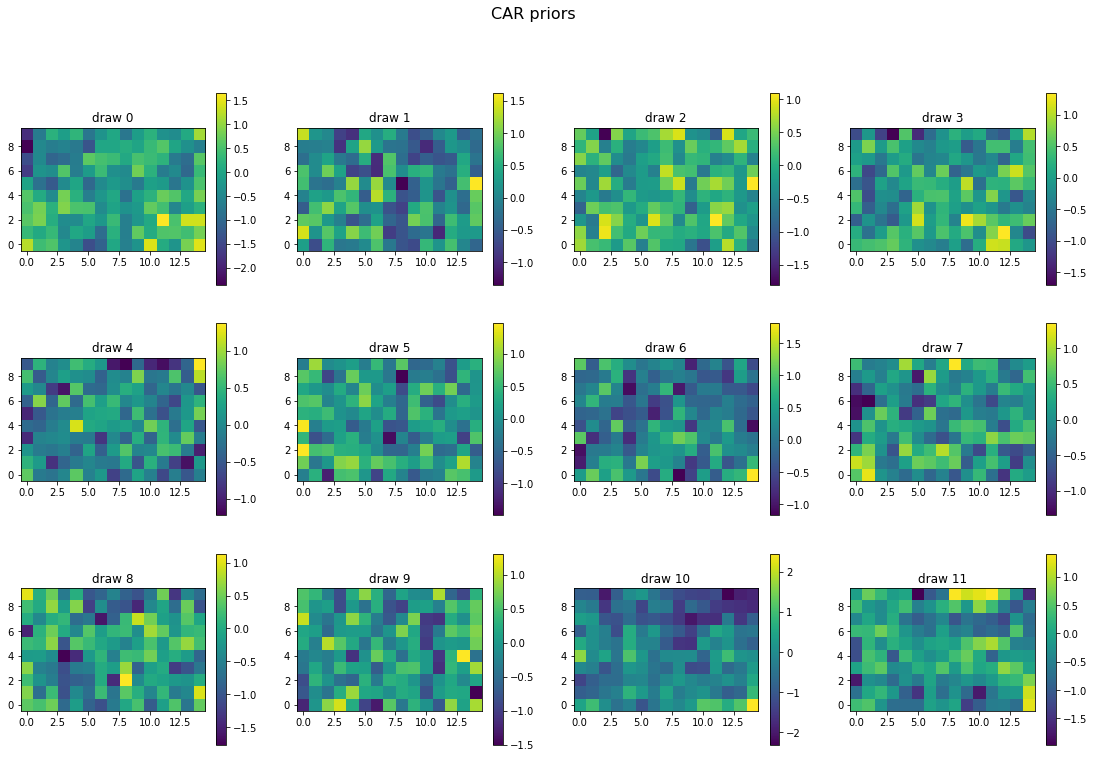

In [9]:
plot_samps(car_draws)

In [10]:
def get_car_draws_as_graph(graph_samples: jnp.ndarray) -> jraph.GraphsTuple:
  G = nx.from_numpy_matrix(A)

  edges = list(G.edges)
  edges += [(edge[1], edge[0]) for edge in edges]
  senders = jnp.asarray([edge[0] for edge in edges])
  receivers = jnp.asarray([edge[1] for edge in edges])

  return jraph.GraphsTuple(
    n_node = jnp.asarray([len(G.nodes)]),
    n_edge = jnp.asarray([len(edges)]),
    nodes=graph_samples.T, # (n_node, batch_size)
    edges=None,
    globals=None,
    senders=senders, 
    receivers=receivers)
  
dataset = []
for i in range(args['batch_size']):
  g = get_car_draws_as_graph(car_draws[i])
  dataset.append({
    'input_graph': g, 
    'target': g.nodes},
  )

In [11]:
# See graph statistics for a single graph
train_graph = dataset[0]['input_graph']
train_senders = train_graph.senders
train_receivers = train_graph.receivers
train_labels = train_graph.nodes

In [12]:
num_nodes = train_graph.n_node.item()
feat_matrix_dim = train_graph.nodes.shape
assert num_nodes == feat_matrix_dim[0], 'num_nodes != feat_matrix_dim[0]'
assert feat_matrix_dim == train_labels.shape, 'feat_matrix_dim != train_labels.shape'
print('Number of nodes:', num_nodes)
print('Feature matrix dim (n_node x n_feat):', feat_matrix_dim)
print('Labels shape:', train_labels.shape)

Number of nodes: 150
Feature matrix dim (n_node x n_feat): (150,)
Labels shape: (150,)


In [13]:
from typing import NamedTuple

class Args(NamedTuple):
  hidden_dim: int 
  latent_dim: int
  output_dim: int
  learning_rate: float
  epochs: int
  eval_frequency : int

In [14]:
rng_key, params_key = jax.random.split(rng_key)

wargs = Args(
  hidden_dim=10,
  latent_dim=5,
  output_dim=1,
  learning_rate=1e-3,
  epochs=300,
  eval_frequency=10,
)

# Initialize network and optimizer.
net = hk.transform(
  lambda x: VGAE(hidden_dim=wargs.hidden_dim, 
                 latent_dim=wargs.latent_dim, 
                 output_dim=wargs.output_dim)(x))
optimizer = optax.adam(wargs.learning_rate)

In [15]:
from model import VGAEOutput
import loss
from loss import compute_kl_gaussian

@jax.jit
def loss_fn(params: hk.Params, 
            rng_key: jnp.ndarray,
            graph: jraph.GraphsTuple,
            targets: jnp.ndarray,
) -> jnp.ndarray:
  """Computes VGAE loss."""
  outputs: VGAEOutput = net.apply(params, rng_key, graph)
  log_likelihood = -loss.compute_frobenius_loss(
    outputs.output.nodes, targets)
  kld = jnp.mean(compute_kl_gaussian(outputs.mean, outputs.log_std), axis=-1)
  elbo = log_likelihood - kld
  return -elbo
  
@jax.jit
def update(
params: hk.Params,
rng_key: jnp.ndarray,
opt_state: optax.OptState,
graph: jraph.GraphsTuple,
targets: jnp.ndarray,
):
  """Updates the parameters of the network."""
  grads = jax.grad(loss_fn)(params, rng_key, graph, targets)
  updates, new_opt_state = optimizer.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state

In [16]:
# Initialize net with an arbitrary graph in dataset
params = net.init(params_key, train_graph)
opt_state = optimizer.init(params)

rng_seq_split_num = (wargs.epochs
                     + 2*(wargs.epochs/100 * wargs.eval_frequency)  # every eval_frequency, we use 2 keys.
                     + 2  # last epoch
                     + 1  # for rng_key
                    )
rng_key, *rng_seq = jax.random.split(rng_key, rng_seq_split_num)
rng_seq = iter(rng_seq)

train_losses = []

for epoch in range(wargs.epochs):
    graph = dataset[epoch % len(dataset)]['input_graph']
    targets = dataset[epoch % len(dataset)]['target']
    
    params, opt_state = update(params, next(rng_seq), opt_state, graph, targets)
  
    if epoch % wargs.eval_frequency == 0 or epoch == (wargs.epochs - 1):
      train_loss = loss_fn(params, next(rng_seq), graph, targets)
      train_losses.append(train_loss)
      train_output = net.apply(params, next(rng_seq), graph)
      print(f'epoch: {epoch}, train_loss: {train_loss:.5f}')

epoch: 0, train_loss: 33.35498
epoch: 10, train_loss: 31.74791
epoch: 20, train_loss: 27.16931
epoch: 30, train_loss: 31.69424
epoch: 40, train_loss: 29.68370
epoch: 50, train_loss: 26.63379
epoch: 60, train_loss: 22.84714
epoch: 70, train_loss: 32.25779
epoch: 80, train_loss: 27.79099
epoch: 90, train_loss: 22.58498
epoch: 100, train_loss: 29.77895
epoch: 110, train_loss: 43.61322
epoch: 120, train_loss: 23.84990
epoch: 130, train_loss: 31.20943
epoch: 140, train_loss: 31.67002
epoch: 150, train_loss: 23.62094
epoch: 160, train_loss: 22.20129
epoch: 170, train_loss: 26.93957
epoch: 180, train_loss: 23.93644
epoch: 190, train_loss: 22.89871
epoch: 200, train_loss: 26.44404
epoch: 210, train_loss: 32.55753
epoch: 220, train_loss: 23.74361
epoch: 230, train_loss: 30.36216
epoch: 240, train_loss: 29.91226
epoch: 250, train_loss: 23.99162
epoch: 260, train_loss: 22.85304
epoch: 270, train_loss: 25.79844
epoch: 280, train_loss: 24.35863
epoch: 290, train_loss: 23.91442
epoch: 299, train_los

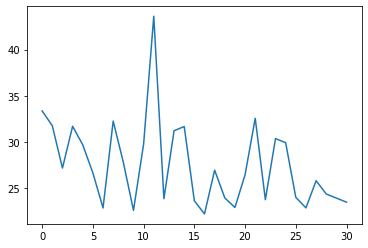

In [17]:
plt.plot(train_losses)

In [18]:
from model import prior_decode
from functools import partial

decoder_params = {
  'decoder_hidden': params['vgae/decoder_hidden'],
  'decoder_output': params['vgae/decoder_output'],
}

decoder_net_fn = partial(prior_decode, hidden_dim=wargs.hidden_dim, output_dim=wargs.output_dim)
decoder_net = hk.transform(decoder_net_fn)

In [19]:
rng_key, *sample_rngs = jax.random.split(rng_key, args['batch_size']+1)

vae_draws = []
for i in range(args['batch_size']):
  z_rng, decoder_rng = jax.random.split(sample_rngs[i])
  z = jax.random.normal(z_rng, shape=(train_graph.n_node.item(), wargs.latent_dim))
  z_graph = train_graph._replace(nodes=z)  # this step assumes only node features are used.
  out_graph = decoder_net.apply(decoder_params, decoder_rng, z_graph)
  vae_draws.append(out_graph.nodes)

vae_draws = jnp.squeeze(jnp.asarray(vae_draws))
assert vae_draws.shape == car_draws.shape

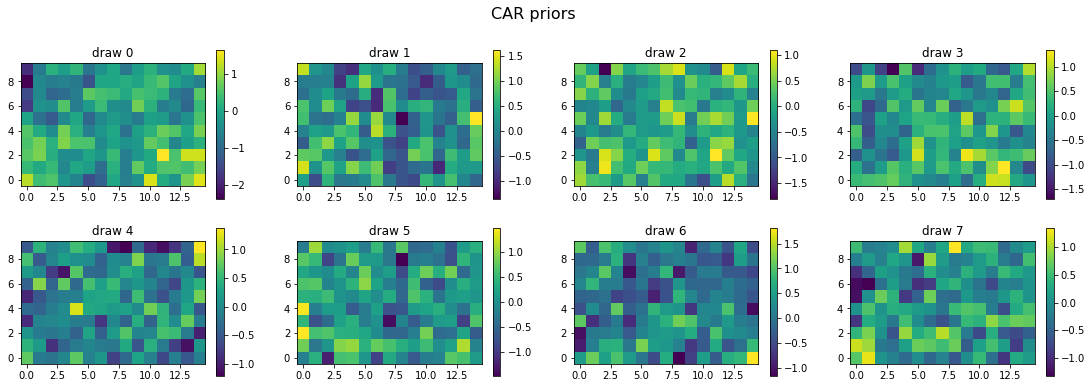

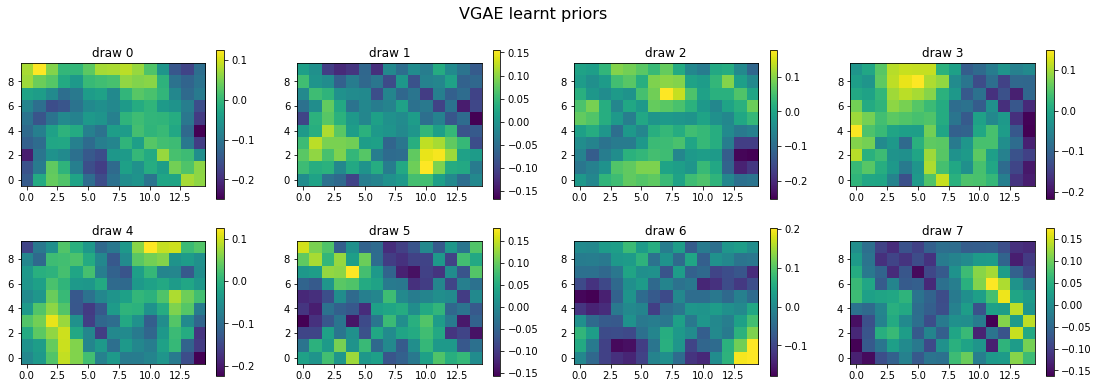

In [20]:
plot_samps(car_draws, rows=2, figsize=(19, 6))
plot_samps(vae_draws, rows=2, figsize=(19, 6), ttl='VGAE learnt priors')

### Inference on observed data with VGAE-CAR

In [21]:
args['decoder_params'] = decoder_params

In [22]:
def CAR_model(args, y=None, alpha=None, noise=None):
    
    A = args["A"]
    d = args["d"]
    D = jnp.diag(d)

    if alpha is None:
        alpha = numpyro.sample('alpha', dist.Uniform(low=0.4, high=0.999))
        
    if noise is None:
        noise = numpyro.sample('noise', dist.Uniform(low=0.01, high=1))
    
    Q = (D - alpha * A)
    
    car = numpyro.sample('car', dist.MultivariateNormal(loc=jnp.zeros(N), precision_matrix=Q))
    car_samples = numpyro.deterministic('car_samples', car)
    
    if y is None: # durinig prediction
        numpyro.sample("y_pred", dist.Normal(car, noise))
    else: # during inference
        numpyro.sample("y", dist.Normal(car, noise), obs=y)

In [23]:
# generate ground truth - fix alpha
rng_key, rng_key_truth = jax.random.split(rng_key)
car_predictive = Predictive(CAR_model, num_samples=1)
car_preds = car_predictive(rng_key_truth, args, alpha=0.7, noise=0.5)
y_data = car_preds['y_pred'][0,:]
y_truth = car_preds['car'][0,:]

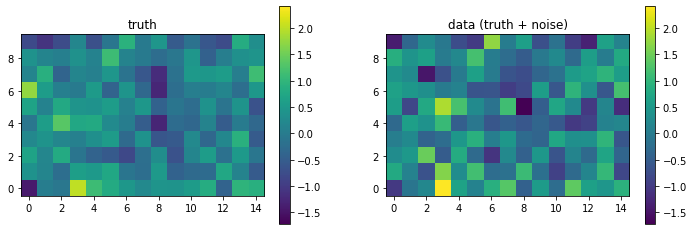

In [24]:
plot_truth_estimate(y_truth, y_data, ttl1="truth", ttl2="data (truth + noise)")

In [25]:
args['hidden_dim'] = wargs.hidden_dim
args['latent_dim'] = wargs.latent_dim
args['output_dim'] = wargs.output_dim
args['train_graph'] = train_graph
args['decoder_net'] = decoder_net

In [26]:
jax.random.normal(rng_key, shape=(args['train_graph'].n_node.item(), wargs.latent_dim)).shape

(150, 5)

In [27]:
def VAE_model(args, y=None, noise=None):
    z = numpyro.sample("z", dist.Normal(0, 1).expand([args['train_graph'].n_node.item(), args['latent_dim']]))
    z_graph = args['train_graph']._replace(nodes=z)  # this step assumes only node features are used.
    
    decoder_params = args["decoder_params"] 
    car_vae = numpyro.deterministic(
        "vae_car", decoder_net.apply(decoder_params, rng_key, z_graph).nodes.T)
    
    if noise is None:
        noise = numpyro.sample('noise', dist.Uniform(low=0.01, high=1))
    
    if y is None: # during prediction
        numpyro.sample("y_pred", dist.Normal(car_vae, noise))
    else: # during inference
        numpyro.sample("y", dist.Normal(car_vae, noise), obs=y)

In [28]:
wargs

Args(hidden_dim=10, latent_dim=5, output_dim=1, learning_rate=0.001, epochs=300, eval_frequency=10)

In [29]:
# VAE-CAR: prior predictive
rng_key, rng_key_ = jax.random.split(rng_key)
prior_predictive = Predictive(VAE_model, num_samples=100)
prior_predictions = prior_predictive(rng_key_, args)
pred_obs = prior_predictions['vae_car']

# Take mean over axis=0 (num_samples) and then over axis=1 (batch_size)
mean_prior_pred_vae = np.mean(pred_obs, axis=(0, 1))
# Original VAE used: mean_prior_pred_vae = np.mean(pred_obs, axis=0)

hpdi_prior_pred_vae = hpdi(pred_obs, 0.89)

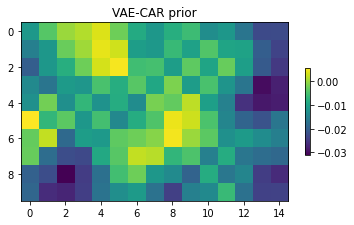

In [30]:
plt.figure()
plt.imshow(mean_prior_pred_vae.reshape(num_y, num_x)) 
plt.colorbar(shrink=0.4)
plt.title("VAE-CAR prior")
plt.show()

In [31]:
# inference
start = time.time()
init_strategy = init_to_median(num_samples=10)
kernel = NUTS(VAE_model, init_strategy=init_strategy)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
rng_key, rng_key_infer = jax.random.split(rng_key)
mcmc.run(rng_key_infer, args, y=y_data)
mcmc_samples = mcmc.get_samples()
mcmc.print_summary(exclude_deterministic=False)
t_elapsed = time.time() - start

sample: 100%|██████████| 3000/3000 [00:06<00:00, 437.22it/s, 15 steps of size 2.69e-01. acc. prob=0.87]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
         noise      0.74      0.05      0.73      0.66      0.81   2937.38      1.00
  vae_car[0,0]     -0.01      0.09     -0.00     -0.16      0.13   1708.66      1.00
  vae_car[0,1]      0.00      0.09      0.01     -0.14      0.15   1966.78      1.00
  vae_car[0,2]      0.03      0.08      0.03     -0.11      0.16   1615.87      1.00
  vae_car[0,3]      0.04      0.08      0.04     -0.09      0.16   1612.40      1.00
  vae_car[0,4]      0.05      0.08      0.05     -0.09      0.16   1484.34      1.00
  vae_car[0,5]      0.03      0.07      0.04     -0.09      0.15   1477.59      1.00
  vae_car[0,6]      0.02      0.07      0.02     -0.09      0.15   1607.01      1.00
  vae_car[0,7]      0.02      0.08      0.02     -0.11      0.14   1743.56      1.00
  vae_car[0,8]      0.01      0.08      0.01     -0.14      0.13   1739.73      1.00
  vae_car[0,9]      0.01      0.08      0.01     -0.13      0.13

In [32]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")
ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))
r = np.mean(ss['vae_car']['n_eff'])
print("Average ESS for all CAR effects : " + str(round(r)))


MCMC elapsed time: 9 s
Average ESS for all CAR effects : 1665


In [33]:
mcmc_samples.keys()

dict_keys(['noise', 'vae_car', 'z'])

In [34]:
# posterior predictive
rng_key, rng_key_ = jax.random.split(rng_key)
posterior_predictive = Predictive(VAE_model, mcmc_samples)
posterior_predictions = posterior_predictive(rng_key_, args)
post_obs = posterior_predictions['vae_car']

# Take mean over axis=0 (num_samples) and then over axis=1 (batch_size)
mean_post_pred_vae = np.mean(post_obs, axis=(0, 1))
hpdi_post_pred_vae = hpdi(post_obs, 0.9)

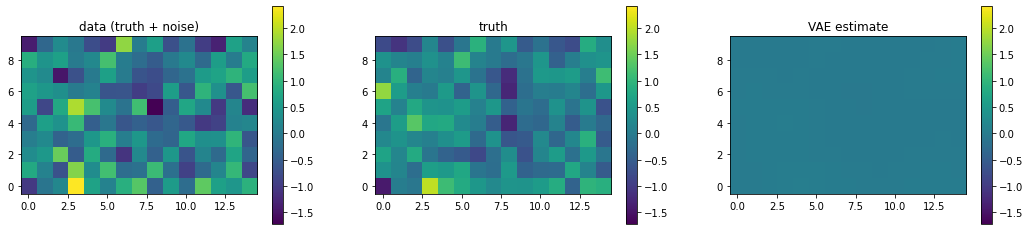

In [35]:
plot_truth_car_vae(y_data, y_truth, 
                   mean_post_pred_vae, 
                   ttl1="data (truth + noise)", ttl2="truth", ttl3="VAE estimate")

Text(0, 0.5, 'VAE post. predictive')

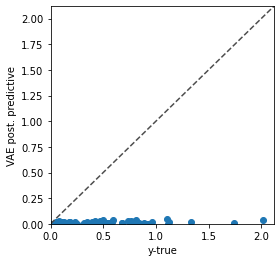

In [36]:
mx = np.max([y_truth, mean_post_pred_vae])
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(y_truth, mean_post_pred_vae)
plt.ylim(0, mx+0.1)
plt.xlim(0, mx+0.1)
plt.axline((1, 1), slope=1, ls="--", c=".3")
plt.xlabel("y-true")
plt.ylabel("VAE post. predictive")

In [37]:
MSE_vae = np.mean((y_truth -  mean_post_pred_vae)**2)
print(MSE_vae)

0.31736985
